# Annotation Processing

**In this Notebook**:  
Annotation files by different annotators (for a given `AnnotationTask` object) are loaded together in an `AnnotationSet` object. This allows to compute:
- annotator statistics (distribution of labels, nb of annotations)
- IAA scores  
- confusion matrices between pairs of annotators 

This also allows to extract the subset of annotations which are found to be  **ambiguous** and need adjudication (annotator disagreement / comments left, indicating doubts).

In [1]:
import pandas as pd
import os
import sys
sys.path.append("../")
from utils.anno import AnnotationSet, AnnotationTask

## Initial annotation trial  
4 annotators : anno1, anno2 with 10 papers (987 sentences) to annotate; anno3, anno4 with 4 papers (246 sentences) to annotate. Guidelines: v1.

### 1. Create `AnnotationTask` and `AnnotationSet`

In [2]:
ANNO_DIR_PATH = "anno-results/"

task = AnnotationTask(
    title = "claims-classification",
    guidelines_path = "guidelines_v1.md",
    labels = ["POS", "NEG", "FACT", "PROSP", "NC"],
    annotators = ["anno1", "anno2", "anno3", "anno4"],
)


aset = AnnotationSet(ANNO_DIR_PATH, task = task)

### 2. Access the annotations, annotator statistics, IA metrics

In [3]:
aset.annotations.head()

,doccano_art_id,sentence_id,text,current_sentence_section,previous_sentence_section,previous_sentence,next_sentence_section,next_sentence,label_anno1,comments_anno1,label_anno2,comments_anno2,label_anno3,comments_anno3,label_anno4,comments_anno4
0,0,0,In this paper we report on a research effort f...,abstract,NaN,NaN,abstract,Three sequential models have been developed fo...,FACT,,FACT,,FACT,,,
1,0,1,Three sequential models have been developed fo...,abstract,abstract,In this paper we report on a research effort f...,abstract,The models have been applied to a Danish and a...,FACT,,FACT,,FACT,,,
2,0,2,The models have been applied to a Danish and a...,abstract,abstract,Three sequential models have been developed fo...,abstract,"Moreover, during the reported research, a meth...",POS,j'hésite entre POS et FACT,POS,,POS,,,
3,0,3,"Moreover, during the reported research, a meth...",abstract,abstract,The models have been applied to a Danish and a...,Introduction,One of the problems relating to sign language ...,FACT,,FACT,,POS,,,
4,0,4,One of the problems relating to sign language ...,Introduction,abstract,"Moreover, during the reported research, a meth...",Introduction,"Therefore, most data collections contain a ver...",NC,,NC,,NC,,,


In [6]:
aset.compute_agreement_metrics()

In [7]:
aset.ia_metrics["cohen_kappa"]

,anno1,anno2,anno3,anno4
anno1,1.000000,0.697647,0.735632,0.0
anno2,0.697647,1.000000,0.671456,0.0
anno3,0.735632,0.671456,1.000000,0.0
anno4,0.000000,0.000000,0.000000,1.0


In [8]:
aset.ia_metrics["krippendorff_alpha"]

0.6939257431457768

In [9]:
anno_pairs = aset.compute_coincidences(split_multi_labels = False)
anno_pairs

{('FACT', 'FACT'): 39,
 ('POS', 'POS'): 142,
 ('FACT', 'POS'): 9,
 ('NC', 'NC'): 747,
 ('NC', 'POS'): 60,
 ('POS', 'PROSP'): 9,
 ('FACT', 'NC'): 24,
 ('FACT#POS', 'FACT#POS'): 2,
 ('FACT#POS', 'POS'): 8,
 ('NC', 'NC#NEG'): 1,
 ('NEG', 'POS'): 11,
 ('FACT', 'FACT#NEG'): 1,
 ('PROSP', 'PROSP'): 7,
 ('FACT', 'FACT#POS'): 2,
 ('NEG#POS', 'POS'): 2,
 ('NC', 'NEG'): 6,
 ('NEG', 'PROSP'): 2,
 ('NC', 'PROSP'): 2,
 ('NC#POS', 'POS'): 1,
 ('NEG', 'NEG'): 4}

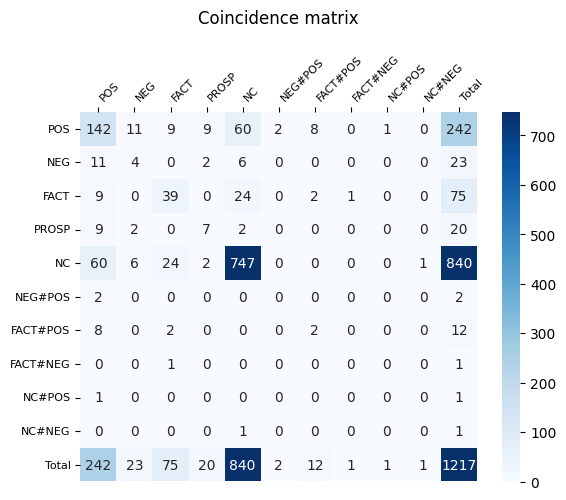

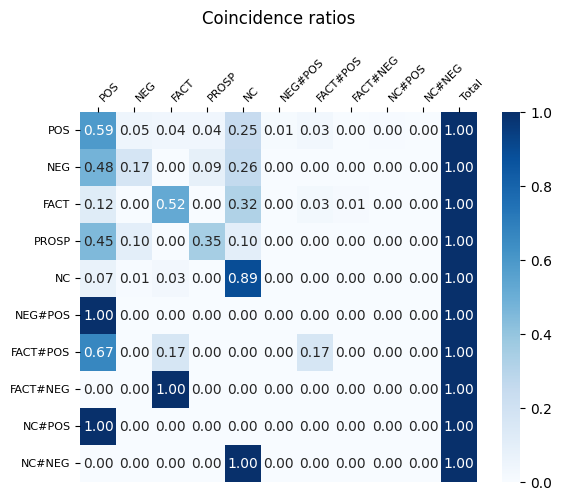

In [11]:
AnnotationSet.plot_coincidence_matrices(anno_pairs, task.multi_labels)

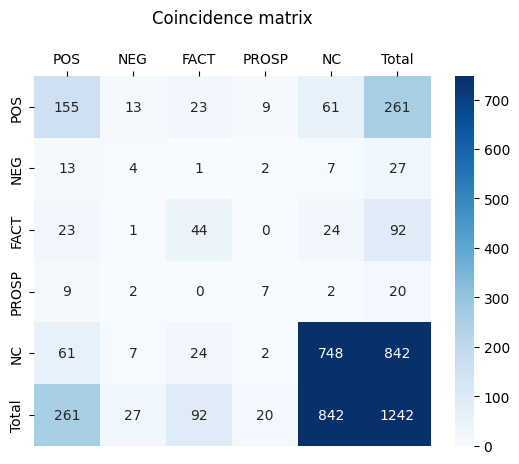

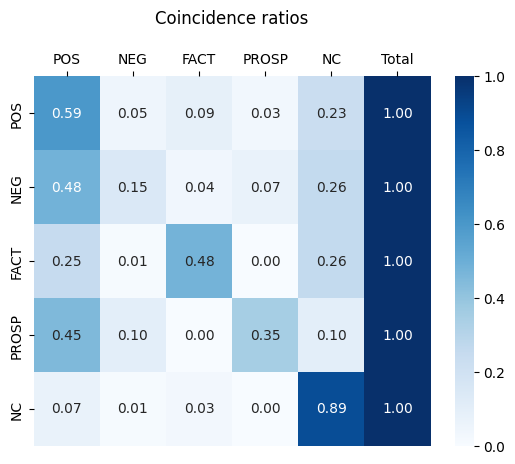

In [12]:
anno_pairs = aset.compute_coincidences(split_multi_labels = True)
AnnotationSet.plot_coincidence_matrices(anno_pairs, task.multi_labels)

In [13]:
aset.compute_ia_confusion_matrices()
cm = aset.ia_metrics["confusion_matrices"][0][1]
cm

array([[135,   9,   4,   4,  23],
       [  2,   4,   0,   0,   0],
       [  1,   0,  30,   0,   7],
       [  3,   2,   0,   7,   2],
       [ 36,   6,  15,   0, 681]], dtype=int64)

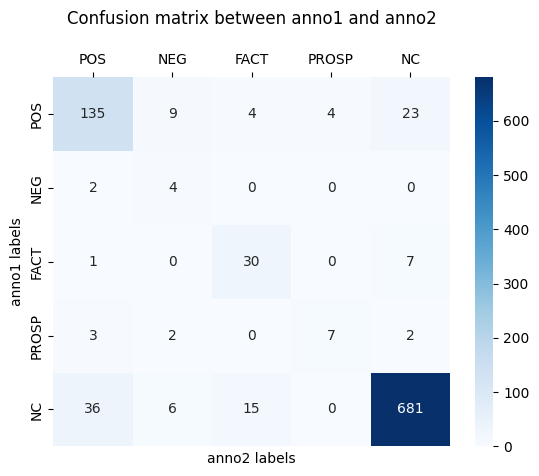

In [14]:
aset.plot_confusion_matrix_for_anno_pair(0, 1)

In [17]:
# from statsmodels.stats.inter_rater import aggregate_raters, fleiss_kappa

# data = []
# for i, row in aset.annotations.iterrows():
#     doc = str(row["doccano_art_id"]) + "-" + str(row["sentence_id"])
#     for anno in aset.task.annotators:
#         label = row[f"label_{anno}"]
#         if label == "":
#             continue

#         data.append([doc, anno, label])

# df = pd.DataFrame(data, columns=["doc", "anno", "label"])
# df

,doc,anno,label
0,0-0,anno1,FACT
1,0-0,anno2,FACT
2,0-0,anno3,FACT
3,0-1,anno1,FACT
4,0-1,anno2,FACT
...,...,...,...
2015,9-232,anno2,NC
2016,9-233,anno1,POS
2017,9-233,anno2,POS
2018,9-234,anno1,PROSP


In [18]:
aset.stats

,POS,NEG,FACT,PROSP,NC,total,POS_rr,NEG_rr,FACT_rr,PROSP_rr,NC_rr,completion_r
anno1,185,7,47,14,740,984,0.188008,0.007114,0.047764,0.014228,0.752033,0.996960
anno2,187,24,54,11,717,987,0.189463,0.024316,0.054711,0.011145,0.726444,1.000000
anno3,8,0,5,1,35,49,0.163265,0.000000,0.102041,0.020408,0.714286,0.049645
anno4,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### 3. Access the ambiguous sentences

In [7]:
df = aset.get_ambiguous_annotations()
df.head()

,doccano_art_id,sentence_id,text,current_sentence_section,previous_sentence_section,previous_sentence,next_sentence_section,next_sentence,label_anno1,comments_anno1,label_anno2,comments_anno2,label_anno3,comments_anno3,label_anno4,comments_anno4,maj_label,agreement,commented
2,0,2,The models have been applied to a Danish and a...,abstract,abstract,Three sequential models have been developed fo...,abstract,"Moreover, during the reported research, a meth...",POS,j'hésite entre POS et FACT,POS,,POS,,,,POS,True,True
3,0,3,"Moreover, during the reported research, a meth...",abstract,abstract,The models have been applied to a Danish and a...,Introduction,One of the problems relating to sign language ...,FACT,,FACT,,POS,,,,FACT,False,False
8,0,8,This way we can extract a dataset with a lot o...,Introduction,Introduction,"Thus, we developed a system in the direction o...",Datasets,For the purposes of the project two collection...,POS,pas sûre,NC,,POS,,,,POS,False,True
21,1,4,"In this paper, we propose a approach for the t...",abstract,abstract,This degrades translation accuracy.,abstract,Experimental results on the United Nations Par...,FACT,,FACT,,POS,,,,FACT,False,False
23,1,6,1,abstract,abstract,Experimental results on the United Nations Par...,Introduction,In statistical machine translation (SMT) (Brow...,NC,problème phrase,NC,,NC,,,,NC,True,True


In [8]:
df.shape

(144, 19)

In [22]:
len(df[df["commented"] == True])

27

In [9]:
df_ambig = df.drop(columns = ["agreement", "commented"])

In [10]:
df_ambig.columns

Index(['doccano_art_id', 'sentence_id', 'text', 'current_sentence_section',
       'previous_sentence_section', 'previous_sentence',
       'next_sentence_section', 'next_sentence', 'label_anno1',
       'comments_anno1', 'label_anno2', 'comments_anno2', 'label_anno3',
       'comments_anno3', 'label_anno4', 'comments_anno4', 'maj_label'],
      dtype='object')

In [11]:
df_ambig = df_ambig[["text", "maj_label", "doccano_art_id", "sentence_id", "label_anno1", "comments_anno1", "label_anno2", "comments_anno2", "label_anno3", "comments_anno3", "label_anno4", "comments_anno4", "previous_sentence_section", "previous_sentence", "next_sentence_section", "next_sentence"]]

In [12]:
df_ambig.head()

,text,maj_label,doccano_art_id,sentence_id,label_anno1,comments_anno1,label_anno2,comments_anno2,label_anno3,comments_anno3,label_anno4,comments_anno4,previous_sentence_section,previous_sentence,next_sentence_section,next_sentence
2,The models have been applied to a Danish and a...,POS,0,2,POS,j'hésite entre POS et FACT,POS,,POS,,,,abstract,Three sequential models have been developed fo...,abstract,"Moreover, during the reported research, a meth..."
3,"Moreover, during the reported research, a meth...",FACT,0,3,FACT,,FACT,,POS,,,,abstract,The models have been applied to a Danish and a...,Introduction,One of the problems relating to sign language ...
8,This way we can extract a dataset with a lot o...,POS,0,8,POS,pas sûre,NC,,POS,,,,Introduction,"Thus, we developed a system in the direction o...",Datasets,For the purposes of the project two collection...
21,"In this paper, we propose a approach for the t...",FACT,1,4,FACT,,FACT,,POS,,,,abstract,This degrades translation accuracy.,abstract,Experimental results on the United Nations Par...
23,1,NC,1,6,NC,problème phrase,NC,,NC,,,,abstract,Experimental results on the United Nations Par...,Introduction,In statistical machine translation (SMT) (Brow...


In [13]:
# df_ambig.to_csv("anno-results/ambig.csv", index = False)

In [14]:
df_ambig["maj_label"].value_counts()

maj_label
NC       68
POS      54
FACT     12
PROSP     8
NEG       2
Name: count, dtype: int64

In [20]:
a = aset.annotations
for l in task.labels:
    print(l)
    ex = a[(a["maj_label"] == l) & (a["agreement"] == True)]["text"].head(5)
    for e in ex:
        print(e)
    print()

POS
The models have been applied to a Danish and a Greek Sign Language dataset, providing results around 96%.
Experimental results on the United Nations Parallel Corpus show the proposed method gains in all tested combinations of language, up to 2.3 BLEU points.
In this way, the model will distinguish translation rules extracted in contexts in which the English symbol string "[X1] record [X2]" behaves as a verbal phrase, from contexts in which the same string acts as nominal phrase.
From the results, we can see that the proposed partial matching method of pivot subtrees in triangulation outperforms the standard triangulation method for all language pairs and achieves higher or almost equal scores than proposed exact matching method.
The exact matching method also outperforms the standard triangulation method in the majority of the language pairs, but has a lesser improvement than partial matching method.

NEG
However, our Spanish annotators had only six hours each, and there was no int

In [24]:
t = df_ambig[df_ambig["comments_anno3"] != ""]["text"].values

In [25]:
t

array(['Among various methods using pivot languages, one popular and effective method is the triangulation method (Utiyama and Isahara, 2007;Cohn and Lapata, 2007), which first combines sourcepivot and pivot-target translation models (TMs) into a source-target model, then translates using this combined model.',
       'Given this background, we hypothesize that disambiguation of these cases would be easier if the necessary syntactic information such as phrase structures are considered during pivoting.'],
      dtype=object)